In [5]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
import misc_funs as misc

from importlib import reload
reload(cgi)

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

pixelscale_lamD = 0.2

iwa = 2.8
owa = 9.7

data_dir = cgi.data_dir

dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

Text(0, 0.5, '$W/m^2/sr/nm$')

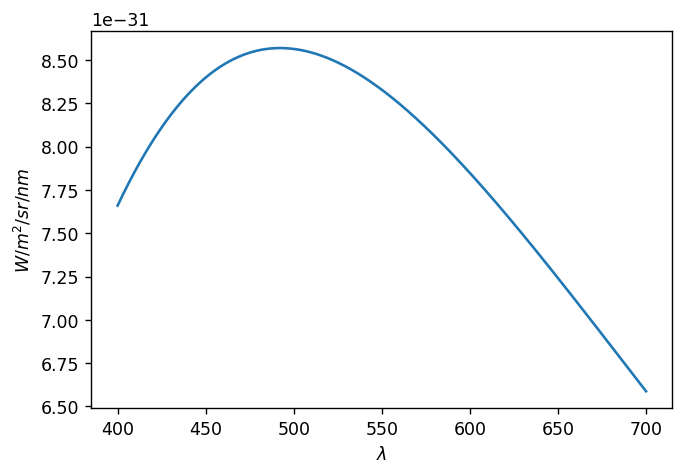

In [6]:
from astropy.constants import h, c, k_B

pupil_diam = 2.36*u.m
d = (14.06*u.parsec).to(u.m)
SA = (((pupil_diam/d)*u.radian)**2).to(u.sr)

T = 5887*u.K

lambdas = np.linspace(400, 700, 10000)*u.nm

spec = 2*h*c**2/(lambdas**5)/(np.exp(h*c/(k_B*T*lambdas)) - 1)/u.sr

spec = spec.to(u.J/u.s/u.sr/u.m**2/u.nm) * SA

fig,ax = plt.subplots(1,1,dpi=125)
ax.plot(lambdas, spec)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$W/m^2/sr/nm$')

In [7]:
from scipy.integrate import simpson

fluxes = []

del_waves = wavelengths[1]-wavelengths[0]

for i in range(nlam):
    wave = wavelengths[i].to(u.nm)
    min_wave = wave-del_waves/2
    max_wave = wave+del_waves/2
    inds = np.where((lambdas>min_wave)&(lambdas<max_wave))
    
    wave_range = lambdas[inds].value
    spec_range = spec[inds].value
#     print(wave_range[0], wave_range[-1])
    
    fluxes.append(simpson(spec_range, wave_range)*u.J/u.s/u.m**2) # integrate over the wave band
    
    E = h*c/wave.to(u.m) / u.photon
    
    fluxes[i] /= E # convert to photons/s/m**2
    
print(fluxes)

[<Quantity 6.59517761e-11 ph / (m2 s)>, <Quantity 6.7388511e-11 ph / (m2 s)>, <Quantity 6.81761501e-11 ph / (m2 s)>]


3.915902040001443e-15 ph / s


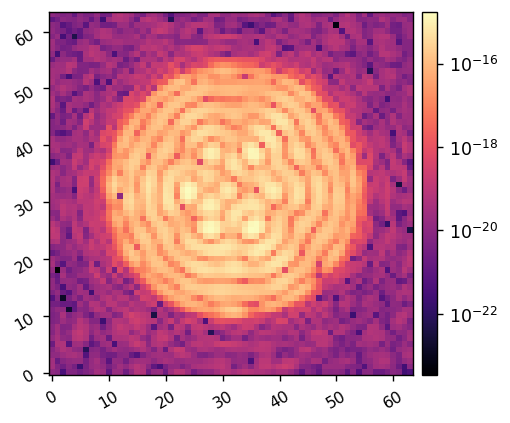

In [8]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=fluxes[1])

hlc.set_dm1(dm1_flat)
hlc.set_dm2(dm2_flat)

im = hlc.snap()
misc.imshow1(im, lognorm=True)

In [9]:
reload(cgi)
CGI = ray.remote(cgi.CGI)

mode_settings = {'cgi_mode':'hlc',
                 'use_pupil_defocus':True, 
                 'use_opds':True,}

actors = []
for i in range(nlam):
    actors.append(CGI.remote(wavelength=wavelengths[i], source_flux=fluxes[i], **mode_settings))


In [10]:
def snap_broadband_im(actors, QE=None, plot=False):
    pending_ims = []
    for i in range(len(actors)):
        actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
        actors[i].set_dm2.remote(dm2_flat)
        
        future_ims = actors[i].snap.remote()
        pending_ims.append(future_ims)
    ims = ray.get(pending_ims)
    
    im = np.sum(ims, axis=0)/len(actors) # average each of the 
    
    clear_output(wait=True)
    if plot:
        for i in range(len(actors)):
            misc.imshow1(ims[i], lognorm=True,)
            
        misc.imshow1(im, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)
    
    return im

In [ ]:
T_bandpass = np.array([])
qe = np.array([])

In [11]:


im = snap_broadband_im(actors, QE=[], plot=False)
misc.imshow1(im, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)


SyntaxError: invalid syntax (2229229651.py, line 1)